# L3: Text clustering and topic modelling

Text clustering groups documents in such a way that documents within a group are more &lsquo;similar&rsquo; to other documents in the cluster than to documents not in the cluster. The exact definition of what &lsquo;similar&rsquo; means in this context varies across applications and clustering algorithms.

In this lab you will experiment with both hard and soft clustering techniques. More specifically, in the first part you will be using the $k$-means algorithm, and in the second part you will be using a topic model based on the Latent Dirichlet Allocation (LDA).

**A quick reminder about our [Rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins) and the [Policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating)**

## Hard clustering data set

The raw data for the hard clustering part of this lab is a collection of product reviews. We have preprocessed the data by tokenization and lowercasing.

In [2]:
import pandas as pd
import bz2

with bz2.open('reviews.json.bz2') as source:
    df = pd.read_json(source)

When you inspect the data frame, you can see that there are three labelled columns: `category` (the product category), `sentiment` (whether the product review was classified as &lsquo;positive&rsquo; or &lsquo;negative&rsquo; towards the product), and `text` (the space-separated text of the review).

In [3]:
df.head()

,category,sentiment,text
0,music,neg,i bought this album because i loved the title ...
1,music,neg,i was misled and thought i was buying the enti...
2,books,neg,"i have introduced many of my ell , high school..."
3,books,pos,anything you purchase in the left behind serie...
4,dvd,pos,"i loved these movies , and i cant wiat for the..."


## Problem 1: K-means clustering

Your first task is to cluster the product review data using a tf–idf vectorizer and a $k$-means clusterer.

Start by doing the vectorization. In connection with vectorization, you should also filter out standard English stop words. While you could use [spaCy](https://spacy.io/) for this task, here it suffices to use the word list implemented in [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

In [4]:
# TODO: Enter code here to vectorize the data and store it in a variable `reviews`
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(stop_words = "english")
reviews = vec.fit_transform(df["text"])

Test your vectorization by running the following code cell:

In [5]:
reviews.shape

(11914, 46619)

If you used the English stop word list from scikit-learn, then the resulting vocabulary should have 46,619 entries.

Next, cluster the vectorized data. Before doing so, you should read the documentation of the [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) class, which is scikit-learn&rsquo;s implementation of the $k$-means algorithm. As you can see, this class has several parameters that you can tweak. For now, the only parameter that you will have to set is the number of clusters. Start with $k=3$.

**Tip:** Training $k$-means models will take some time. To speed things up, you can use the `n_init` parameter to control the number of times that the clustering is re-computed with different initial values. The default value for this parameter is 10; here and in the rest of this lab, you may want to set this to a lower value.

In [6]:
# TODO: Enter code here to cluster the vectorized data
from sklearn.cluster import KMeans
kmean_res = KMeans(n_clusters=3,n_init=5).fit(reviews)

To sanity-check your clustering, create a bar plot with the number of documents per cluster.

<AxesSubplot:xlabel='0'>

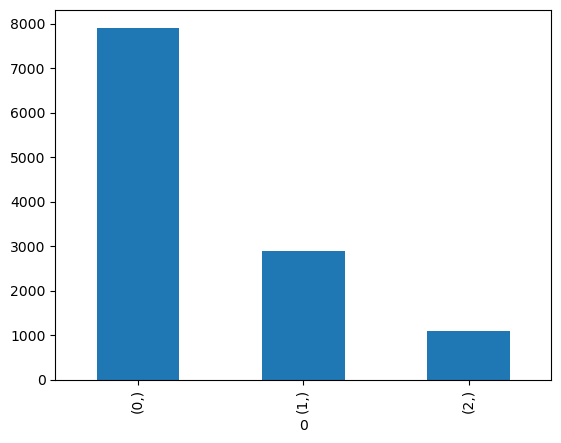

In [7]:
# TODO: Enter code here to produce a bar plot of the cluster size
pd.DataFrame(kmean_res.labels_).value_counts().plot(kind='bar')

Note that sizes may vary considerable between clusters and among different random seeds.

## Problem 2: Summarize clusters

Once you have a clustering, you can try to see whether it is meaningful. One useful technique in that context is to generate a **summary** for each cluster by extracting the $n$ highest-weighted terms from the centroid of each cluster. Your next task is to implement this approach.

**Hint:** You will need to construct an &lsquo;inverted vocabulary&rsquo; that allows you to map from the index of a term back to the original term.

In [8]:
# TODO: Enter code here to compute the cluster summaries and print them
import numpy as np

# voca_ is dict in the form of {word:index}
voca_ = vec.vocabulary_
for i in range(3):
    # argsort return the index
    res = np.argsort(kmean_res.cluster_centers_[i,:])[-10:]
    t= {s for s in voca_ if voca_[s] in res}
    print(t)

{'like', 'time', 'album', 'product', 'good', 'use', 'cd', 'does', 'great', 'just'}
{'book', 'like', 'story', 'movie', 'good', 'film', 'read', 'great', 'quot', 'just'}
{'quality', 'flash', 'canon', 'battery', 'pictures', 'camera', 'lens', 'use', 'digital', 'great'}


The first cluster is about digital camera.  
The second cluster si about media entertainment.  
The third cluster is about book.

Once you have computed the cluster summaries, take a minute to reflect on their quality. Is it clear what the reviews in a given cluster are about? Do the cluster summaries contain any unexpected terms?

## Problem 3: Compare clusterings using the Rand index

In some scenarios, you may have gold-standard class labels available for at least a subset of your documents. In these cases you can compute the **Rand index** of a clustering, and use this measure to compare the quality of different clusterings.

To compute the Rand index, we view a clustering as a binary classifier on (unordered) pairs of documents. The classifier predicts &lsquo;positive&rsquo; if and only if the two documents belong to the same cluster. The (non-normalized) Rand index of the clustering is the accuracy of this classifier relative to a reference in which a document pair belongs to the &lsquo;positive&rsquo; class if and only if the two documents in the pair have the same gold-standard class label. You are supposed to implement the procedure yourselves, not import an external function.

Compare clusterings with $k \in \{1,3,5,7\}$ clusters. As your evaluation data, use the first 500 documents from the original data set along with their gold-standard categories (from the `category` column).

In [9]:
# TODO: Enter code here to (manually) compute the Rand indices for the two clusterings
ground_truth = df["category"][:500]
data = reviews[:500,:]
preds = kmean_res.predict(data)
def rand_index(truth,pred):
    n = len(pred)
    tot = n*(n-1)/2 
    a = 0
    b = 0
    for i in range(n):
        for j in range(i+1,n):
            if pred[i] == pred[j] and truth[i]==truth[j]:
                a = a + 1
            if pred[i] != pred[j] and truth[i]!=truth[j]:
                b = b + 1
    return (a+b)/tot

for i in [1,3,5,7,9]:
    kmean_res = KMeans(n_clusters=i).fit(reviews)
    pred = kmean_res.predict(data)
    print(rand_index(ground_truth, pred))

0.16626052104208416
0.4384529058116233
0.6644488977955911
0.7548136272545091
0.7604008016032064


*TODO: Insert a summary of your results here*  
**Summary:**  
The result above shows clustering with 7 center performs best. We can also check total number of class type by `print(len(set(ground_truth)))`, and we can see the ground truth is 6. That's why 7 has the highest rand index score.

In [10]:
print(len(set(ground_truth)))

6


## Topic modelling data set

The data set for the topic modelling part of this lab is the collection of all [State of the Union](https://en.wikipedia.org/wiki/State_of_the_Union) addresses from the years 1975–2000. These speeches come as a single text file with one sentence per line. The following code cell prints the first 5 lines from the data file:

In [11]:
with open('sotu_1975_2000.txt') as source:
    for i, line in enumerate(source):
        print(line.rstrip())
        if i >= 5:
            break

mr speaker mr vice president members of the 94th congress and distinguished guests
twenty six years ago a freshman congressman a young fellow with lots of idealism who was out to change the world stood before sam rayburn in the well of the house and solemnly swore to the same oath that all of you took yesterday an unforgettable experience and i congratulate you all
two days later that same freshman stood at the back of this great chamber over there someplace as president truman all charged up by his single handed election victory reported as the constitution requires on the state of the union
when the bipartisan applause stopped president truman said i am happy to report to this 81st congress that the state of the union is good our nation is better able than ever before to meet the needs of the american people and to give them their fair chance in the pursuit of happiness it is foremost among the nations of the world in the search for peace
today that freshman member from michigan stan

Take a few minutes to think about what topics you would expect in this data set.

## Problem 4: Train a topic model

Your first task on the topic modelling data is to train an LDA model. For this task you will be using [spaCy](https://spacy.io/) and the [gensim](https://radimrehurek.com/gensim/) topic modelling library.

Start by preprocessing the data using spaCy. Given that the data set for this problem is rather small, you do not have to exclude any components from the standard pipeline. Filter out stop words, non-alphabetic tokens, and tokens less than 3 characters in length. Store the documents as a nested list where the first level of nesting corresponds to the sentences and the second level corresponds to the tokens in each sentence.

In [12]:
# TODO: Replace the following lines with your own code for preprocessing the documents
import spacy
with open('sotu_1975_2000.txt') as source:
    nlp = spacy.load("en_core_web_sm")
    documents = [[token.text for token in nlp(line) if token.is_stop == False and token.is_alpha == True and len(token) > 2]  for line in source]

Test your preprocessing by running the following cell:

In [15]:
' '.join(documents[42])
print(type(documents[0]))


<class 'list'>


You should get the following output:

Once you have the list of documents, skim the section [Pre-process and vectorize the documents](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#pre-process-and-vectorize-the-documents) of the gensim documentation to learn how to create the dictionary and the vectorized corpus representation required by gensim. (Note that you cannot use the standard scikit-learn pipeline in this case.) Then, write code to train an [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) for $k=10$ topics, and using default values for all other parameters.

In [27]:
# TODO: Enter code here to train an LDA model and store it in a variable `model`
from gensim.corpora import Dictionary
from gensim.models import LdaModel

dic = Dictionary(documents)
vec_corpus = [dic.doc2bow(line) for line in documents]
dic[0]
model = LdaModel(corpus=vec_corpus,id2word=dic.id2token,num_topics=10)

Once you have a trained model, run the following cell to print the topics:

In [28]:
model.print_topics()

[(0,
  '0.017*"work" + 0.016*"america" + 0.014*"children" + 0.014*"people" + 0.010*"new" + 0.009*"let" + 0.008*"american" + 0.007*"care" + 0.006*"welfare" + 0.006*"americans"'),
 (1,
  '0.011*"new" + 0.008*"years" + 0.007*"world" + 0.007*"congress" + 0.007*"nation" + 0.007*"people" + 0.007*"year" + 0.006*"time" + 0.006*"america" + 0.006*"national"'),
 (2,
  '0.009*"america" + 0.008*"world" + 0.005*"crime" + 0.005*"peace" + 0.005*"freedom" + 0.005*"years" + 0.005*"nations" + 0.004*"year" + 0.004*"allies" + 0.004*"time"'),
 (3,
  '0.014*"government" + 0.007*"people" + 0.006*"tax" + 0.005*"congress" + 0.005*"help" + 0.005*"states" + 0.005*"northern" + 0.005*"work" + 0.005*"tobacco" + 0.005*"federal"'),
 (4,
  '0.010*"america" + 0.007*"right" + 0.007*"teen" + 0.006*"people" + 0.006*"ask" + 0.006*"help" + 0.006*"years" + 0.006*"know" + 0.005*"congress" + 0.005*"american"'),
 (5,
  '0.010*"years" + 0.009*"million" + 0.009*"year" + 0.006*"world" + 0.005*"american" + 0.005*"people" + 0.005*"pe

Inspect the topics. Can you &lsquo;label&rsquo; each topic with a short description of what it is about? Do the topics match your expectations?

0: It's about social welfare.  
1: Can't tell.  
2: It's about social security and crime.  
3: government policy about tobacco and tax.  
4: no idea  
5: families statistics in america  
6: no idea  
7: no idea  
8: no idea  
9: no idea

## Problem 5: Monitor a topic model for convergence

When learning an LDA model, it is important to make sure that the training algorithm has converged to a stable posterior distribution. One way to do so is to plot, after each training epochs (or &lsquo;pass&rsquo;, in gensim parlance) the log likelihood of the training data under the posterior. Your last task in this lab is to create such a plot and, based on this, to suggest an appropriate number of epochs.

To collect information about the posterior likelihood after each pass, we need to enable the logging facilities of gensim. Once this is done, gensim will add various diagnostics to a log file `gensim.log`.

In [30]:
import logging

logging.basicConfig(filename='gensim.log', format='%(asctime)s:%(levelname)s:%(message)s', level=logging.INFO)

The following function will parse the generated logfile and return the list of log likelihoods.

In [31]:
import re

def parse_logfile():
    matcher = re.compile('(-*\d+\.\d+) per-word .* (\d+\.\d+) perplexity')
    likelihoods = []
    with open('gensim.log') as source:
        for line in source:
            match = matcher.search(line)
            if match:
                likelihoods.append(float(match.group(1)))
    return likelihoods

Your task now is to re-train your LDA model for 50&nbsp;passes, retrieve the list of log likelihoods, and create a plot from this data.

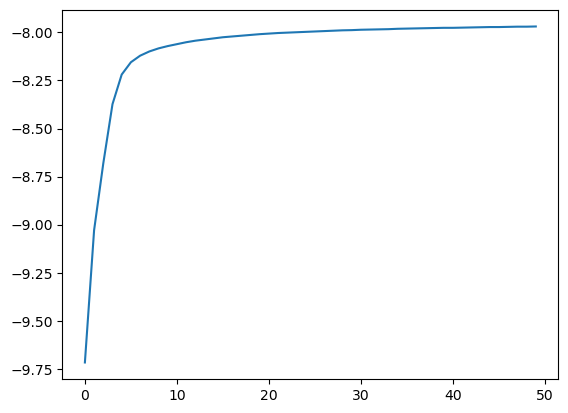

In [32]:
# TODO: Enter code here to generate the convergence plot
import matplotlib.pyplot as plt
model = LdaModel(corpus=vec_corpus,id2word=dic.id2token,num_topics=10,passes=50)
plt.plot(parse_logfile())

How do you interpret your plot? Based on the plot, what would be a reasonable choice for the number of passes? Retrain your LDA model with that number and re-inspect the topics it finds. Do you consider the new topics to be &lsquo;better&rsquo; than the ones that you got from the 1-pass model in Problem&nbsp;4?

The likelihood curve start to meet convergence when passes are above 40.

In [33]:
model = LdaModel(corpus=vec_corpus,id2word=dic.id2token,num_topics=10,passes=40)
model.print_topics()

[(0,
  '0.016*"schools" + 0.014*"children" + 0.013*"school" + 0.012*"college" + 0.012*"help" + 0.010*"know" + 0.010*"people" + 0.009*"congress" + 0.009*"teachers" + 0.009*"community"'),
 (1,
  '0.024*"federal" + 0.020*"tax" + 0.016*"government" + 0.016*"budget" + 0.013*"new" + 0.011*"year" + 0.011*"congress" + 0.011*"education" + 0.010*"spending" + 0.010*"billion"'),
 (2,
  '0.026*"america" + 0.022*"people" + 0.016*"americans" + 0.015*"american" + 0.014*"world" + 0.012*"new" + 0.011*"years" + 0.011*"let" + 0.011*"century" + 0.010*"work"'),
 (3,
  '0.011*"year" + 0.008*"government" + 0.008*"reform" + 0.007*"new" + 0.007*"people" + 0.006*"hold" + 0.006*"senate" + 0.006*"covenant" + 0.006*"campaign" + 0.005*"teen"'),
 (4,
  '0.017*"children" + 0.016*"work" + 0.012*"thank" + 0.012*"child" + 0.009*"parents" + 0.009*"crime" + 0.009*"welfare" + 0.008*"bill" + 0.008*"people" + 0.008*"need"'),
 (5,
  '0.014*"trade" + 0.010*"world" + 0.010*"environment" + 0.010*"protect" + 0.007*"water" + 0.007*

0: education 
1: tax and national budget  
2: no idea  
3: america policy and new policy  
4: child-care and family  
5: globalization and environment    
6: economy  
7: family health care  
8: social security  
9: military topics  
We can see now the theme of each topic are clearer than topics in question4.

## Reflection questions

The following reflection questions will help you prepare for the diagnostic test. Answer each of them in the form of a short text and put your answers in the cell below. You will get feedback on your answers from your lab assistant.

**RQ 3.1:** Based on your experiments in Problem&nbsp;2 and Problem&nbsp;3, what is the relation between the quality of a clustering and the number of clusters? What happens when the number of clusters is too low, or too high? For this particular data set, what would a &lsquo;good&rsquo; number of clusters be?

**RQ 3.2:** Explain why it is important to monitor an LDA model for convergence and not simply use, say, 1000&nbsp;passes. How is the log likelihood used in this context? Were the topics from the multi-pass model &lsquo;better&rsquo; than the topics from the 1-pass model?

**RQ 3.3:** What are the differences between $k$-means and LDA? When would you use one, when the other?

**A 3.1**:  
If the number of clusters is too low, one cluster may contain key words from different topics, so it;s hard to tell the theme of the text.  
If the number of clusters is too high, some clusters may have too specific words so it's hard to generalize.  
Only when number of clusters match the ground truth (or some specific requirements), will the quality of clusters become good. In this task, the best number of clusters is 7 according to the results in P3.

**A 3.2**:  
Because when training the model, time-efficiency is also a huge concern. If the likelihood converge when passes is 40, then there is no need to use higher passes since the improvement cannot match the time cost. And the log-likelihood here is a tool to score how well the model perform.  

In this lab, multi-passes is better than 1-pass model. But in other tasks it may differ.

**A 3.3**:  
k-means is hard classifier and LDA is a soft model. For topic modelling, LDA is better and for data clustering we can use k-means.

**Congratulations on finishing L3! 👍**